In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
# Read file
with open("/content/wiki.train.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

clean_lines = []

for line in lines:
    line = line.strip()

    # Skip wiki headers like "= = Gameplay = ="
    if line.startswith("="):
        continue

    # Fix hyphen tokens
    line = line.replace("@-@", "-")

    # Remove <unk>
    line = line.replace("<unk>", "")

    clean_lines.append(line)

# Join everything
data = " ".join(clean_lines)

# Remove extra spaces
data = " ".join(data.split())

print(data[:500])

Senjō no Valkyria 3 : Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role - playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . the same fusion of tactical and real - time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , 


In [3]:
import re

# Fix spaced hyphen words
data = re.sub(r'\s-\s', '-', data)

data[:500]

'Senjō no Valkyria 3 : Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role-playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . the same fusion of tactical and real-time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a pe'

In [4]:
import re

# Remove space before punctuation
data = re.sub(r'\s([,.!?;:])', r'\1', data)

# Remove space before closing bracket
data = re.sub(r'\s([\)\]])', r'\1', data)

# Remove space after opening bracket
data = re.sub(r'([\(\[])\s', r'\1', data)

# Fix quote spacing
data = re.sub(r'\s+"', '"', data)
data = re.sub(r'"\s+', '"', data)


In [5]:
data[:500]

'Senjō no Valkyria 3: Chronicles (Japanese: 戦場のヴァルキュリア3, lit. Valkyria of the Battlefield 3), commonly referred to as Valkyria Chronicles III outside Japan, is a tactical role-playing video game developed by Sega and Media.Vision for the PlayStation Portable. Released in January 2011 in Japan, it is the third game in the Valkyria series. the same fusion of tactical and real-time gameplay as its predecessors, the story runs parallel to the first game and follows the"Nameless", a penal military uni'

In [6]:
len(data)

9898687

In [7]:
data = data.lower()

In [8]:
VOCAB_SIZE = 10000 # limit vocab for stability

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts([data])
total_words = VOCAB_SIZE
print("Vocabulary size:", total_words)

Vocabulary size: 10000


In [9]:
sequence = tokenizer.texts_to_sequences([data])[0]

In [10]:
sequence_length = 5
input_sequences = []

for i in range(sequence_length, len(sequence)):
    input_sequences.append(sequence[i-sequence_length:i+1])

input_sequences = np.array(input_sequences)

X = input_sequences[:, :-1]
y = input_sequences[:, -1]


print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1691677, 5)
y shape: (1691677,)


In [11]:
print("Max y:", y.max())

Max y: 9999


In [12]:
MAX_SAMPLES = 300000   # even 200k is fine

X = X[:MAX_SAMPLES]
y = y[:MAX_SAMPLES]


In [13]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (300000, 5)
y shape: (300000,)


In [14]:
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(5,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=100),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(VOCAB_SIZE, activation='softmax')
])


In [19]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=5e-4, clipnorm=1.0)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


In [20]:
total_words

10000

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 5, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10000)          │     1,010,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,090,400 (7.97 MB)

 Trainable params: 2,090,400 (7.97 MB)

 Non-trainable params: 0 (0.00 B)

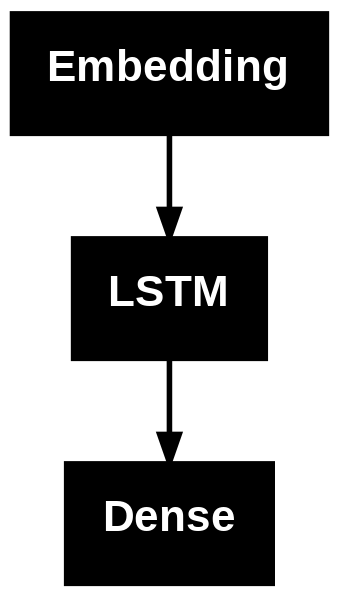

In [22]:
from tensorflow import keras
from keras.utils import plot_model

keras.utils.plot_model(model, to_file='plot.png')

In [23]:
history = model.fit(
    X,
    y,
    epochs=5,
    batch_size=256,
    validation_split=0.1
)

Epoch 1/5
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.0748 - loss: 7.2409 - val_accuracy: 0.1063 - val_loss: 6.7883
Epoch 2/5
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.1096 - loss: 6.4441 - val_accuracy: 0.1197 - val_loss: 6.6881
Epoch 3/5
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.1246 - loss: 6.2724 - val_accuracy: 0.1280 - val_loss: 6.6355
Epoch 4/5
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.1326 - loss: 6.1583 - val_accuracy: 0.1311 - val_loss: 6.6284
Epoch 5/5
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.1396 - loss: 6.0580 - val_accuracy: 0.1345 - val_loss: 6.6120


In [33]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequence_length = 5  # must match training

def predict_next(seed_text):
    seed_text = seed_text.lower()

    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = token_list[-sequence_length:]

    token_list = pad_sequences(
        [token_list],
        maxlen=sequence_length,
        padding='pre'
    )

    predictions = model.predict(token_list, verbose=0)[0]
    top_indices = predictions.argsort()[::-1]  # sorted descending

    suggestions = []

    for idx in top_indices:
        word = tokenizer.index_word.get(idx, "")
        if word and word != "<OOV>":
            suggestions.append(word)
        if len(suggestions) == 3:
            break

    return suggestions


# -------- User Input --------
user_input = input("Enter text: ")
print("Top 3 predictions:", predict_next(user_input))

Enter text: i wish you good
Top 3 predictions: ['and', 'in', 'the']
